In [1]:
%run ./Definitions.ipynb
!nvidia-smi
import os

2020-01-07 14:38:53.321376
thunder  Tue Jan  7 14:38:53 2020
[0] GeForce GTX 1080 Ti | 40'C,   0 % |    10 / 11178 MB |
[1] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[2] GeForce GTX 1080 Ti | 26'C,   0 % |    10 / 11178 MB |
[3] GeForce GTX 1080 Ti | 25'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 23'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 27'C,   0 % |    10 / 11178 MB |
[6] GeForce GTX 1080 Ti | 29'C,   0 % | 10895 / 11178 MB | anthoula(10885M)
[7] GeForce GTX 1080 Ti | 27'C,   0 % | 10895 / 11178 MB | anthoula(10885M)


/ds/environments/python2020/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/ds/environments/python2020/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Dataset consist of 85730 patients data with 6251 features for each patient
Function definitions executed
Definitions DONE !!

Tue Jan  7 14:39:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   40C    P0    59W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 29%   25C    P8     7W / 250W |     10Mi

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # choose here your GPU (0-7)

import tensorflow as tf
import tensorflow.compat.v1 as tf
import keras
# from keras import backend as K
import tensorflow.python.keras.backend as K


In [3]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

### LOAD valid train test and validation image names 

In [4]:
valid_traindf_names = pd.read_pickle(funduspath_CR + 'valid_traindf_names.pkl')
valid_valdf_names = pd.read_pickle(funduspath_CR + 'valid_valdf_names.pkl')
valid_testdf_names = pd.read_pickle(funduspath_CR + 'valid_testdf_names.pkl')

valid_traindf_names.shape , valid_valdf_names.shape , valid_testdf_names.shape

((101834, 5), (33943, 5), (33936, 5))

In [5]:
img_size = 250
red_size = 224

srcpath = '/ds2/data/retina/UK_BB/UK_BB_DATA/fundus/'
funduspath_CR = DATA_dir + 'Fundus_images_250_CR/'
trainpath = funduspath_CR + 'train/'
valpath = funduspath_CR + 'val/'
testpath = funduspath_CR + 'test/'

## Handling Imbalanced Data sets

In [6]:
which_gt = 4 # CHANGE 1,2,3,4 implies 'GT523', 'GT19', 'GTi', 'GTu'
n_NG = 0 # non glaucoma
n_G = 0  # glaucoma

GT_dict = {1:'GT523',2:'GT19',3:'GTi',4:'GTu'}
Class = GT_dict[which_gt]
temp = valid_traindf_names[Class]
for i in range(len(temp)):
    if(temp[i] == '1'):
        n_G += 1
    else:
        n_NG += 1
        
print("No. of Glaucoma patients in training set:",n_G)
print("No. of non-Glaucoma patients in training set:",n_NG)

No. of Glaucoma patients in training set: 2379
No. of non-Glaucoma patients in training set: 99455


### 1. Over Sampling Train set

In [7]:
# Oversample the minority class

X_train = valid_traindf_names['Fundus_Filenames']
y_train = valid_traindf_names[GT_dict[which_gt]]

# Converting class values to int 1 or 0
y_train = y_train.astype(int)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_glaucoma = X[X[Class]==0]
glaucoma = X[X[Class]==1]

# upsample minority
glaucoma_upsampled = resample(glaucoma,
                              replace=True, # sample with replacement
                              n_samples=len(not_glaucoma), # match number in majority class
                              random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_glaucoma,glaucoma_upsampled])

# shuffle upsampled dataframe for training
upsampled = upsampled.sample(frac=1)


In [8]:
X[Class].value_counts()

0    99455
1     2379
Name: GTu, dtype: int64

In [9]:
upsampled[Class].value_counts()

1    99455
0    99455
Name: GTu, dtype: int64

#### validation distribution

In [47]:
valid_valdf_names[Class].value_counts()

0    33134
1      809
Name: GTu, dtype: int64

#### test distribution

In [49]:
valid_testdf_names[Class].value_counts()

0    33163
1      773
Name: GTu, dtype: int64

### Oversampling minority with less imbalance - in train set
Original imbalance ratio **X-** 1:40

Imbalance ratio **up1**-1:5, **up2**-1:10, **up3**-1:20, **up4**-1:30

Balanced ratio **upsampled**-1:1

In [11]:
# upsampling minority
glaucoma_up1 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/5), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up2 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/10), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up3 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/20), # match number in majority class
                        random_state=42) # reproducible results

glaucoma_up4 = resample(glaucoma, replace=True, # sample with replacement 
                        n_samples=floor(len(not_glaucoma)/30), # match number in majority class
                        random_state=42) # reproducible results

# combine majority and upsampled minority
up1 = pd.concat([not_glaucoma,glaucoma_up1])
up2 = pd.concat([not_glaucoma,glaucoma_up2])
up3 = pd.concat([not_glaucoma,glaucoma_up3])
up4 = pd.concat([not_glaucoma,glaucoma_up4])

# shuffle upsampled dataframe for training
up1 = up1.sample(frac=1)
up2 = up2.sample(frac=1)
up3 = up3.sample(frac=1)
up4 = up4.sample(frac=1)


In [12]:
print("up1")
print(up1[Class].value_counts())
print("up2")
print(up2[Class].value_counts())
print("up1")
print(up3[Class].value_counts())
print("up4")
print(up4[Class].value_counts())

up1
0    99455
1    19891
Name: GTu, dtype: int64
up2
0    99455
1     9945
Name: GTu, dtype: int64
up1
0    99455
1     4972
Name: GTu, dtype: int64
up4
0    99455
1     3315
Name: GTu, dtype: int64


### 2. Class weight

In [13]:
# # Setting class weight for retraining:

# # compute_class_weight('balanced', np.unique(y_train), y_train)
# class_weight = [0.5, 2] # experiment with different values
n_NG , n_G

(99455, 2379)

## Define Model and Metrics

In [14]:
# reg_values = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] # 1e-1, 
reg_value = 0.001
METRICS = [keras.metrics.BinaryAccuracy(name='Accuracy'),
           Precision, 
           Recall, 
           F1,
           keras.metrics.AUC(name='AUC')]

def mobilenet_model():       
    mobile_conv = MobileNet(weights='imagenet', include_top=False, input_shape=(red_size, red_size, 3))

    # UnFreeze last conv layer
    for layer in mobile_conv.layers[:78]:
        layer.trainable = False
    for layer in mobile_conv.layers[78:]:
        layer.trainable = True
        
    # Create the model
    model = models.Sequential()
    model.add(mobile_conv)
 
    # Add new layers
    # https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(1, activation='sigmoid'))
 
    return model

### Augmentation
https://nbviewer.jupyter.org/github/aleju/imgaug-doc/blob/master/notebooks/A01%20-%20Load%20and%20Augment%20an%20Image.ipynb

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(scale=1.1),
    iaa.Affine(rotate=(-10, 10)),
    # iaa.GammaContrast(0.9),
    iaa.Resize({"height": 230, "width": 230}),
    iaa.CropToFixedSize(width=red_size, height=red_size)
    ])

### Flow from Dataframe
https://www.kaggle.com/dmitrypukhov/cnn-with-imagedatagenerator-flow-from-dataframe

Normalizing using ImageDataGenerator https://stackoverflow.com/questions/41855512/how-does-data-normalization-work-in-keras-during-prediction

In [16]:
valid_traindf_names[Class] = valid_traindf_names[Class].astype(int)
valid_valdf_names[Class] = valid_valdf_names[Class].astype(int)

In [17]:
# To use same settings as mobilenet
# from keras.applications.mobilenet import preprocess_input
# train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_datagen = ImageDataGenerator(preprocessing_function=seq.augment_image, samplewise_center=True,
                                   featurewise_center=True, featurewise_std_normalization=True,
                                   rescale= 1./127.5-1) 
val_datagen = ImageDataGenerator(samplewise_center=True,
                                 featurewise_center=True, featurewise_std_normalization=True,
                                 rescale=1./127.5-1)  
BATCH_SIZE = 32

print("\nOriginal imbalanced train data: ")
imb_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = valid_traindf_names, # imbalanced train dataframe
    directory=trainpath,
    x_col=valid_traindf_names.columns[0],
    y_col=valid_traindf_names.columns[which_gt],
#     x_col = upsampled.columns[0], # upsampled data
#     y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nOriginal validation data: ")
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_valdf_names,
    directory=valpath,
    x_col=valid_valdf_names.columns[0],
    y_col=valid_valdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUpsampled train data 1:1 ")
up_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = upsampled, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = upsampled.columns[0], # upsampled data
    y_col = upsampled.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP1 train data 1:5 ")
up1_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up1, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up1.columns[0], # upsampled data
    y_col = up1.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP2 train data 1:10 ")
up2_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up2, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up2.columns[0], # upsampled data
    y_col = up2.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP3 train data 1:20 ")
up3_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up3, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up3.columns[0], # upsampled data
    y_col = up3.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

print("\nUP4 train data 1:30 ")
up4_train_generator = train_datagen.flow_from_dataframe(
    # dataframe=valid_traindf_names,
    dataframe = up4, # upsampled data
    directory=trainpath,
    # x_col=valid_traindf_names.columns[0],
    # y_col=valid_traindf_names.columns[which_gt],
    x_col = up4.columns[0], # upsampled data
    y_col = up4.columns[1], # upsampled data
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)



Original imbalanced train data: 
Found 101834 validated image filenames.

Original validation data: 
Found 33943 validated image filenames.

Upsampled train data 1:1 
Found 198910 validated image filenames.

UP1 train data 1:5 
Found 119346 validated image filenames.

UP2 train data 1:10 
Found 109400 validated image filenames.

UP3 train data 1:20 
Found 104427 validated image filenames.

UP4 train data 1:30 
Found 102770 validated image filenames.


### Choosing parameters and model compile

In [18]:
which_model = mobilenet_model
# which_model = vgg_model

model = which_model()
learning_rate  = 0.0001 
decay = 1e-5
momentum=0.9
opt = Adam(lr=learning_rate, decay = decay) 
model.compile(loss='binary_crossentropy', metrics=METRICS, optimizer=opt)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 1,589,249
Non-trainable params: 1,640,640
_________________________________________________________________


In [19]:
# With L2 weight regularizer
# es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001, verbose=1)
n_epochs=200
n_steps_per_epoch = 50
n_validation_steps = 10

### Train with upsampled data (1:1)

In [20]:
start = time.time()
up_history = model.fit_generator(up_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              callbacks=[reduce_lr]
                             )
end = time.time()

/ds/environments/python2020/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:339: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(values, collections.Sequence):


Epoch 1/200


/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/ds/environments/python2020/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


50/50 [==============================] - 23s 455ms/step - loss: 0.7633 - Accuracy: 0.5638 - Precision: 0.5745 - Recall: 0.4461 - F1: 0.4699 - AUC: 0.5881 - val_loss: 0.4654 - val_Accuracy: 0.9062 - val_Precision: 0.0450 - val_Recall: 0.2000 - val_F1: 0.0733 - val_AUC: 0.6765
Epoch 2/200
50/50 [==============================] - 21s 425ms/step - loss: 0.6635 - Accuracy: 0.6106 - Precision: 0.5877 - Recall: 0.6178 - F1: 0.5940 - AUC: 0.6607 - val_loss: 0.4767 - val_Accuracy: 0.9375 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_F1: 0.0000e+00 - val_AUC: 0.3403
Epoch 3/200
50/50 [==============================] - 23s 463ms/step - loss: 0.6544 - Accuracy: 0.6169 - Precision: 0.6173 - Recall: 0.6046 - F1: 0.6046 - AUC: 0.6764 - val_loss: 0.5763 - val_Accuracy: 0.7000 - val_Precision: 0.0568 - val_Recall: 0.1667 - val_F1: 0.0816 - val_AUC: 0.5165
Epoch 4/200
50/50 [==============================] - 24s 470ms/step - loss: 0.6414 - Accuracy: 0.6331 - Precision: 0.6277 - Recall: 0.64

Epoch 29/200
50/50 [==============================] - 24s 482ms/step - loss: 0.5833 - Accuracy: 0.6994 - Precision: 0.7108 - Recall: 0.7220 - F1: 0.7103 - AUC: 0.7605 - val_loss: 1.7442 - val_Accuracy: 0.0281 - val_Precision: 0.0250 - val_Recall: 0.5000 - val_F1: 0.0471 - val_AUC: 0.6018
Epoch 30/200
50/50 [==============================] - 24s 477ms/step - loss: 0.5654 - Accuracy: 0.7050 - Precision: 0.7034 - Recall: 0.7395 - F1: 0.7127 - AUC: 0.7788 - val_loss: 1.5988 - val_Accuracy: 0.0125 - val_Precision: 0.0063 - val_Recall: 0.2000 - val_F1: 0.0121 - val_AUC: 0.4929
Epoch 31/200
50/50 [==============================] - 24s 486ms/step - loss: 0.5635 - Accuracy: 0.7131 - Precision: 0.6942 - Recall: 0.7478 - F1: 0.7118 - AUC: 0.7842 - val_loss: 1.4438 - val_Accuracy: 0.0312 - val_Precision: 0.0190 - val_Recall: 0.5000 - val_F1: 0.0364 - val_AUC: 0.6760
Epoch 32/200
50/50 [==============================] - 24s 483ms/step - loss: 0.5574 - Accuracy: 0.7212 - Precision: 0.7047 - Recall: 

50/50 [==============================] - 21s 417ms/step - loss: 0.5779 - Accuracy: 0.6975 - Precision: 0.6935 - Recall: 0.7230 - F1: 0.7015 - AUC: 0.7637 - val_loss: 1.4421 - val_Accuracy: 0.0344 - val_Precision: 0.0251 - val_Recall: 0.6000 - val_F1: 0.0480 - val_AUC: 0.5741
Epoch 58/200
50/50 [==============================] - 23s 453ms/step - loss: 0.5645 - Accuracy: 0.7069 - Precision: 0.7006 - Recall: 0.7481 - F1: 0.7173 - AUC: 0.7768 - val_loss: 1.4905 - val_Accuracy: 0.0188 - val_Precision: 0.0125 - val_Recall: 0.2000 - val_F1: 0.0232 - val_AUC: 0.4216
Epoch 59/200
50/50 [==============================] - 24s 474ms/step - loss: 0.5642 - Accuracy: 0.7138 - Precision: 0.7065 - Recall: 0.7464 - F1: 0.7198 - AUC: 0.7781 - val_loss: 1.4981 - val_Accuracy: 0.0250 - val_Precision: 0.0190 - val_Recall: 0.6000 - val_F1: 0.0367 - val_AUC: 0.6282
Epoch 60/200
50/50 [==============================] - 24s 483ms/step - loss: 0.5518 - Accuracy: 0.7150 - Precision: 0.6934 - Recall: 0.7507 - F1: 

50/50 [==============================] - 24s 479ms/step - loss: 0.5662 - Accuracy: 0.7088 - Precision: 0.6864 - Recall: 0.7370 - F1: 0.7051 - AUC: 0.7796 - val_loss: 1.4867 - val_Accuracy: 0.0344 - val_Precision: 0.0190 - val_Recall: 0.4000 - val_F1: 0.0360 - val_AUC: 0.4560
Epoch 86/200
50/50 [==============================] - 24s 482ms/step - loss: 0.5572 - Accuracy: 0.7188 - Precision: 0.7184 - Recall: 0.7408 - F1: 0.7216 - AUC: 0.7852 - val_loss: 1.3613 - val_Accuracy: 0.0156 - val_Precision: 0.0094 - val_Recall: 0.3000 - val_F1: 0.0182 - val_AUC: 0.6614
Epoch 87/200
50/50 [==============================] - 24s 478ms/step - loss: 0.5679 - Accuracy: 0.6931 - Precision: 0.6828 - Recall: 0.7150 - F1: 0.6909 - AUC: 0.7742 - val_loss: 1.4341 - val_Accuracy: 0.0344 - val_Precision: 0.0127 - val_Recall: 0.4000 - val_F1: 0.0246 - val_AUC: 0.4996
Epoch 88/200
50/50 [==============================] - 24s 482ms/step - loss: 0.5671 - Accuracy: 0.7044 - Precision: 0.7175 - Recall: 0.7330 - F1: 

50/50 [==============================] - 24s 483ms/step - loss: 0.5586 - Accuracy: 0.7144 - Precision: 0.7119 - Recall: 0.7394 - F1: 0.7178 - AUC: 0.7844 - val_loss: 1.4195 - val_Accuracy: 0.0281 - val_Precision: 0.0127 - val_Recall: 0.3000 - val_F1: 0.0243 - val_AUC: 0.3604
Epoch 114/200
50/50 [==============================] - 24s 476ms/step - loss: 0.5608 - Accuracy: 0.7212 - Precision: 0.7083 - Recall: 0.7424 - F1: 0.7201 - AUC: 0.7830 - val_loss: 1.4866 - val_Accuracy: 0.0281 - val_Precision: 0.0220 - val_Recall: 0.7000 - val_F1: 0.0426 - val_AUC: 0.5988
Epoch 115/200
50/50 [==============================] - 24s 471ms/step - loss: 0.5573 - Accuracy: 0.7094 - Precision: 0.6887 - Recall: 0.7434 - F1: 0.7074 - AUC: 0.7875 - val_loss: 1.4775 - val_Accuracy: 0.0375 - val_Precision: 0.0283 - val_Recall: 0.6000 - val_F1: 0.0538 - val_AUC: 0.5456
Epoch 116/200
50/50 [==============================] - 24s 478ms/step - loss: 0.5619 - Accuracy: 0.7163 - Precision: 0.7061 - Recall: 0.7489 - F

50/50 [==============================] - 24s 479ms/step - loss: 0.5562 - Accuracy: 0.7206 - Precision: 0.6994 - Recall: 0.7585 - F1: 0.7203 - AUC: 0.7901 - val_loss: 1.4041 - val_Accuracy: 0.0656 - val_Precision: 0.0478 - val_Recall: 0.7000 - val_F1: 0.0863 - val_AUC: 0.4273
Epoch 142/200
50/50 [==============================] - 24s 477ms/step - loss: 0.5586 - Accuracy: 0.7094 - Precision: 0.6940 - Recall: 0.7345 - F1: 0.7071 - AUC: 0.7842 - val_loss: 1.3614 - val_Accuracy: 0.0437 - val_Precision: 0.0317 - val_Recall: 0.5500 - val_F1: 0.0597 - val_AUC: 0.4490
Epoch 143/200
50/50 [==============================] - 24s 484ms/step - loss: 0.5475 - Accuracy: 0.7200 - Precision: 0.7111 - Recall: 0.7362 - F1: 0.7148 - AUC: 0.7976 - val_loss: 1.3740 - val_Accuracy: 0.0719 - val_Precision: 0.0424 - val_Recall: 0.8000 - val_F1: 0.0798 - val_AUC: 0.6309
Epoch 144/200
50/50 [==============================] - 24s 479ms/step - loss: 0.5494 - Accuracy: 0.7325 - Precision: 0.7544 - Recall: 0.7456 - F

50/50 [==============================] - 24s 488ms/step - loss: 0.5208 - Accuracy: 0.7400 - Precision: 0.7223 - Recall: 0.7706 - F1: 0.7399 - AUC: 0.8262 - val_loss: 1.3020 - val_Accuracy: 0.0375 - val_Precision: 0.0252 - val_Recall: 0.7000 - val_F1: 0.0485 - val_AUC: 0.6006
Epoch 170/200
50/50 [==============================] - 24s 476ms/step - loss: 0.5322 - Accuracy: 0.7519 - Precision: 0.7472 - Recall: 0.7695 - F1: 0.7519 - AUC: 0.8190 - val_loss: 1.4019 - val_Accuracy: 0.0688 - val_Precision: 0.0479 - val_Recall: 0.8000 - val_F1: 0.0873 - val_AUC: 0.5425
Epoch 171/200
50/50 [==============================] - 24s 481ms/step - loss: 0.5470 - Accuracy: 0.7244 - Precision: 0.7376 - Recall: 0.7455 - F1: 0.7329 - AUC: 0.7970 - val_loss: 1.3586 - val_Accuracy: 0.0469 - val_Precision: 0.0256 - val_Recall: 0.6000 - val_F1: 0.0485 - val_AUC: 0.4165
Epoch 172/200
50/50 [==============================] - 24s 477ms/step - loss: 0.5521 - Accuracy: 0.7219 - Precision: 0.6981 - Recall: 0.7688 - F

50/50 [==============================] - 24s 489ms/step - loss: 0.5480 - Accuracy: 0.7169 - Precision: 0.7125 - Recall: 0.7338 - F1: 0.7159 - AUC: 0.7954 - val_loss: 1.4945 - val_Accuracy: 0.0344 - val_Precision: 0.0283 - val_Recall: 0.7000 - val_F1: 0.0542 - val_AUC: 0.3621
Epoch 198/200
50/50 [==============================] - 24s 479ms/step - loss: 0.5717 - Accuracy: 0.7088 - Precision: 0.7118 - Recall: 0.7515 - F1: 0.7198 - AUC: 0.7705 - val_loss: 1.2400 - val_Accuracy: 0.0500 - val_Precision: 0.0100 - val_Recall: 0.2000 - val_F1: 0.0190 - val_AUC: 0.3766
Epoch 199/200
50/50 [==============================] - 24s 476ms/step - loss: 0.5592 - Accuracy: 0.7013 - Precision: 0.7036 - Recall: 0.7142 - F1: 0.7024 - AUC: 0.7817 - val_loss: 1.3001 - val_Accuracy: 0.0437 - val_Precision: 0.0289 - val_Recall: 0.5000 - val_F1: 0.0542 - val_AUC: 0.7656
Epoch 200/200
50/50 [==============================] - 24s 480ms/step - loss: 0.5669 - Accuracy: 0.7094 - Precision: 0.6918 - Recall: 0.7429 - F

In [21]:
print("Time taken:",end-start)

Time taken: 4757.743375778198


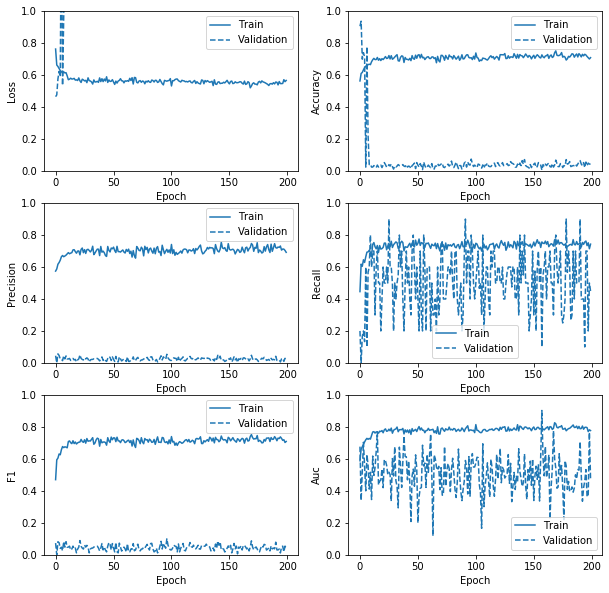

In [22]:
plt.figure(figsize=(10,10))
plot_metrics(up_history)

### Train with UP2 (1:10)

In [23]:
# start = time.time()
# up2_history = model.fit_generator(up2_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps,
#                               class_weight = [1.5,0.5],
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [24]:
# print("Time taken:",end-start)

In [25]:
# plt.figure(figsize=(10,10))
# plot_metrics(up2_history)

### Train with UP3 (1:20)

In [26]:
start = time.time()
up3_history = model.fit_generator(up3_train_generator, 
                              epochs=n_epochs, 
                              steps_per_epoch=n_steps_per_epoch,
                              validation_data=validation_generator,
                              validation_steps=n_validation_steps, 
                              class_weight = {0:0.5,1:3},
                              callbacks=[reduce_lr]
                             )
end = time.time()

Epoch 1/200
50/50 [==============================] - 21s 422ms/step - loss: 0.4064 - Accuracy: 0.5412 - Precision: 0.0785 - Recall: 0.7383 - F1: 0.1395 - AUC: 0.8133 - val_loss: 1.4227 - val_Accuracy: 0.0437 - val_Precision: 0.0348 - val_Recall: 0.7500 - val_F1: 0.0661 - val_AUC: 0.6370
Epoch 2/200
50/50 [==============================] - 20s 390ms/step - loss: 0.3973 - Accuracy: 0.5775 - Precision: 0.1012 - Recall: 0.7377 - F1: 0.1728 - AUC: 0.8285 - val_loss: 1.4005 - val_Accuracy: 0.0250 - val_Precision: 0.0064 - val_Recall: 0.1500 - val_F1: 0.0121 - val_AUC: 0.3252
Epoch 3/200
50/50 [==============================] - 19s 378ms/step - loss: 0.3986 - Accuracy: 0.5956 - Precision: 0.0996 - Recall: 0.6917 - F1: 0.1685 - AUC: 0.7977 - val_loss: 1.4952 - val_Accuracy: 0.0437 - val_Precision: 0.0256 - val_Recall: 0.5000 - val_F1: 0.0481 - val_AUC: 0.3668
Epoch 4/200
50/50 [==============================] - 17s 339ms/step - loss: 0.3846 - Accuracy: 0.6087 - Precision: 0.0853 - Recall: 0.65

50/50 [==============================] - 18s 352ms/step - loss: 0.2748 - Accuracy: 0.8562 - Precision: 0.1767 - Recall: 0.5767 - F1: 0.2532 - AUC: 0.8478 - val_loss: 1.1648 - val_Accuracy: 0.0812 - val_Precision: 0.0140 - val_Recall: 0.4000 - val_F1: 0.0271 - val_AUC: 0.3774
Epoch 30/200
50/50 [==============================] - 15s 298ms/step - loss: 0.2925 - Accuracy: 0.8350 - Precision: 0.1532 - Recall: 0.4930 - F1: 0.2142 - AUC: 0.8147 - val_loss: 1.1211 - val_Accuracy: 0.1031 - val_Precision: 0.0138 - val_Recall: 0.4000 - val_F1: 0.0267 - val_AUC: 0.5511
Epoch 31/200
50/50 [==============================] - 14s 288ms/step - loss: 0.2759 - Accuracy: 0.8456 - Precision: 0.1500 - Recall: 0.4700 - F1: 0.2104 - AUC: 0.8016 - val_loss: 1.0108 - val_Accuracy: 0.1469 - val_Precision: 0.0187 - val_Recall: 0.4500 - val_F1: 0.0358 - val_AUC: 0.4172
Epoch 32/200
50/50 [==============================] - 17s 338ms/step - loss: 0.2907 - Accuracy: 0.8431 - Precision: 0.1724 - Recall: 0.4683 - F1: 

50/50 [==============================] - 14s 271ms/step - loss: 0.2711 - Accuracy: 0.9131 - Precision: 0.2087 - Recall: 0.3337 - F1: 0.2394 - AUC: 0.8099 - val_loss: 0.9007 - val_Accuracy: 0.2250 - val_Precision: 0.0319 - val_Recall: 0.5500 - val_F1: 0.0594 - val_AUC: 0.6258
Epoch 58/200
50/50 [==============================] - 14s 273ms/step - loss: 0.2764 - Accuracy: 0.9112 - Precision: 0.3247 - Recall: 0.4300 - F1: 0.3347 - AUC: 0.8486 - val_loss: 0.9334 - val_Accuracy: 0.2188 - val_Precision: 0.0304 - val_Recall: 0.6000 - val_F1: 0.0572 - val_AUC: 0.4866
Epoch 59/200
50/50 [==============================] - 18s 363ms/step - loss: 0.3089 - Accuracy: 0.9081 - Precision: 0.2389 - Recall: 0.2820 - F1: 0.2204 - AUC: 0.7461 - val_loss: 0.9138 - val_Accuracy: 0.2313 - val_Precision: 0.0165 - val_Recall: 0.3500 - val_F1: 0.0314 - val_AUC: 0.2907
Epoch 60/200
50/50 [==============================] - 18s 368ms/step - loss: 0.2790 - Accuracy: 0.9019 - Precision: 0.1863 - Recall: 0.2417 - F1: 

50/50 [==============================] - 17s 338ms/step - loss: 0.2516 - Accuracy: 0.9219 - Precision: 0.2250 - Recall: 0.2943 - F1: 0.2338 - AUC: 0.8318 - val_loss: 0.7725 - val_Accuracy: 0.4406 - val_Precision: 0.0550 - val_Recall: 0.6000 - val_F1: 0.0986 - val_AUC: 0.6953
Epoch 86/200
50/50 [==============================] - 13s 261ms/step - loss: 0.2503 - Accuracy: 0.9244 - Precision: 0.2117 - Recall: 0.1483 - F1: 0.1491 - AUC: 0.8265 - val_loss: 0.7868 - val_Accuracy: 0.3906 - val_Precision: 0.0201 - val_Recall: 0.3500 - val_F1: 0.0380 - val_AUC: 0.4994
Epoch 87/200
50/50 [==============================] - 17s 344ms/step - loss: 0.3021 - Accuracy: 0.9181 - Precision: 0.2183 - Recall: 0.2173 - F1: 0.1906 - AUC: 0.8056 - val_loss: 0.7402 - val_Accuracy: 0.3688 - val_Precision: 0.0043 - val_Recall: 0.0500 - val_F1: 0.0080 - val_AUC: 0.3222
Epoch 88/200
50/50 [==============================] - 16s 320ms/step - loss: 0.2678 - Accuracy: 0.9200 - Precision: 0.2137 - Recall: 0.2267 - F1: 

50/50 [==============================] - 14s 290ms/step - loss: 0.2772 - Accuracy: 0.9275 - Precision: 0.2300 - Recall: 0.1850 - F1: 0.1850 - AUC: 0.8127 - val_loss: 0.7666 - val_Accuracy: 0.4656 - val_Precision: 0.0232 - val_Recall: 0.2333 - val_F1: 0.0419 - val_AUC: 0.5315
Epoch 114/200
50/50 [==============================] - 13s 266ms/step - loss: 0.2575 - Accuracy: 0.9194 - Precision: 0.1367 - Recall: 0.2017 - F1: 0.1520 - AUC: 0.7678 - val_loss: 0.7736 - val_Accuracy: 0.4563 - val_Precision: 0.0124 - val_Recall: 0.1500 - val_F1: 0.0225 - val_AUC: 0.4168
Epoch 115/200
50/50 [==============================] - 18s 365ms/step - loss: 0.2826 - Accuracy: 0.9219 - Precision: 0.1733 - Recall: 0.1750 - F1: 0.1608 - AUC: 0.7588 - val_loss: 0.7175 - val_Accuracy: 0.3938 - val_Precision: 0.0153 - val_Recall: 0.1667 - val_F1: 0.0273 - val_AUC: 0.5149
Epoch 116/200
50/50 [==============================] - 19s 376ms/step - loss: 0.2882 - Accuracy: 0.9175 - Precision: 0.2150 - Recall: 0.2350 - F

50/50 [==============================] - 17s 343ms/step - loss: 0.2874 - Accuracy: 0.9181 - Precision: 0.2833 - Recall: 0.2667 - F1: 0.2448 - AUC: 0.8101 - val_loss: 0.7354 - val_Accuracy: 0.4031 - val_Precision: 0.0202 - val_Recall: 0.2833 - val_F1: 0.0372 - val_AUC: 0.3929
Epoch 142/200
50/50 [==============================] - 13s 265ms/step - loss: 0.2980 - Accuracy: 0.9225 - Precision: 0.1067 - Recall: 0.1167 - F1: 0.1017 - AUC: 0.7478 - val_loss: 0.8046 - val_Accuracy: 0.3812 - val_Precision: 0.0179 - val_Recall: 0.2500 - val_F1: 0.0332 - val_AUC: 0.4916
Epoch 143/200
50/50 [==============================] - 17s 331ms/step - loss: 0.2712 - Accuracy: 0.9287 - Precision: 0.2500 - Recall: 0.2417 - F1: 0.2193 - AUC: 0.8089 - val_loss: 0.7296 - val_Accuracy: 0.3875 - val_Precision: 0.0178 - val_Recall: 0.1500 - val_F1: 0.0300 - val_AUC: 0.3657
Epoch 144/200
50/50 [==============================] - 14s 278ms/step - loss: 0.2919 - Accuracy: 0.9125 - Precision: 0.0400 - Recall: 0.0400 - F

50/50 [==============================] - 15s 296ms/step - loss: 0.2582 - Accuracy: 0.9194 - Precision: 0.1357 - Recall: 0.1573 - F1: 0.1308 - AUC: 0.7994 - val_loss: 0.7200 - val_Accuracy: 0.5000 - val_Precision: 0.0321 - val_Recall: 0.2500 - val_F1: 0.0556 - val_AUC: 0.3924
Epoch 170/200
50/50 [==============================] - 17s 349ms/step - loss: 0.2671 - Accuracy: 0.9272 - Precision: 0.1967 - Recall: 0.2517 - F1: 0.2001 - AUC: 0.7985 - val_loss: 0.6803 - val_Accuracy: 0.4688 - val_Precision: 0.0193 - val_Recall: 0.2500 - val_F1: 0.0356 - val_AUC: 0.4928
Epoch 171/200
50/50 [==============================] - 15s 295ms/step - loss: 0.2737 - Accuracy: 0.9175 - Precision: 0.2573 - Recall: 0.2280 - F1: 0.2249 - AUC: 0.8191 - val_loss: 0.7893 - val_Accuracy: 0.4656 - val_Precision: 0.0205 - val_Recall: 0.2500 - val_F1: 0.0377 - val_AUC: 0.4911
Epoch 172/200
50/50 [==============================] - 17s 340ms/step - loss: 0.2672 - Accuracy: 0.9275 - Precision: 0.2263 - Recall: 0.2383 - F

50/50 [==============================] - 20s 396ms/step - loss: 0.2813 - Accuracy: 0.9162 - Precision: 0.1533 - Recall: 0.1717 - F1: 0.1527 - AUC: 0.7766 - val_loss: 0.6986 - val_Accuracy: 0.5531 - val_Precision: 0.0346 - val_Recall: 0.3500 - val_F1: 0.0623 - val_AUC: 0.5702
Epoch 198/200
50/50 [==============================] - 19s 390ms/step - loss: 0.2503 - Accuracy: 0.9275 - Precision: 0.1450 - Recall: 0.1580 - F1: 0.1287 - AUC: 0.7985 - val_loss: 0.6008 - val_Accuracy: 0.5844 - val_Precision: 0.0340 - val_Recall: 0.2167 - val_F1: 0.0578 - val_AUC: 0.4563
Epoch 199/200
50/50 [==============================] - 16s 323ms/step - loss: 0.2528 - Accuracy: 0.9237 - Precision: 0.2200 - Recall: 0.2167 - F1: 0.1934 - AUC: 0.8671 - val_loss: 0.6339 - val_Accuracy: 0.5250 - val_Precision: 0.0454 - val_Recall: 0.5000 - val_F1: 0.0826 - val_AUC: 0.6561
Epoch 200/200
50/50 [==============================] - 15s 292ms/step - loss: 0.2665 - Accuracy: 0.9281 - Precision: 0.1900 - Recall: 0.1400 - F

In [27]:
print("Time taken:",end-start)

Time taken: 3180.7959060668945


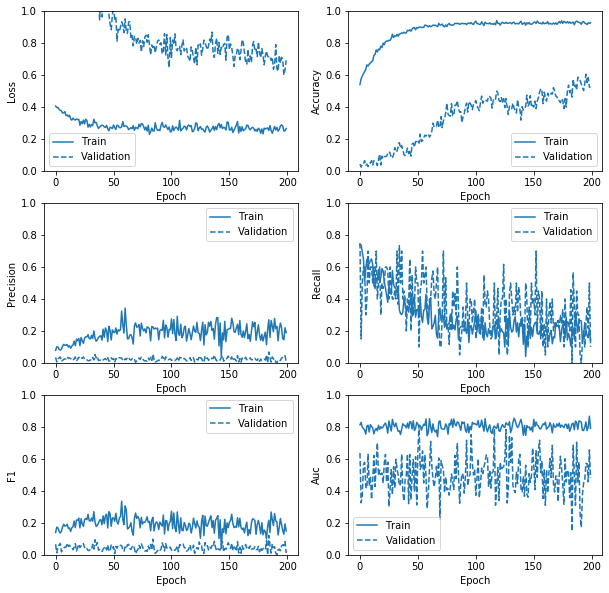

In [28]:
plt.figure(figsize=(10,10))
plot_metrics(up3_history)

### Train with UP4 (1:30)

In [29]:
# start = time.time()
# up4_history = model.fit_generator(up4_train_generator, 
#                               epochs=n_epochs, 
#                               steps_per_epoch=n_steps_per_epoch,
#                               validation_data=validation_generator,
#                               validation_steps=n_validation_steps, 
#                               callbacks=[reduce_lr]
#                              )
# end = time.time()

In [30]:
# print("Time taken:",end-start)

In [31]:
# plt.figure(figsize=(10,10))
# plot_metrics(up4_history)

### Train with Imbalanced original train data (1:40)

In [32]:
# start = time.time()
# imb_history = model.fit_generator(imb_train_generator,
#                                   epochs=n_epochs,
#                                   steps_per_epoch=n_steps_per_epoch,
#                                   validation_data=validation_generator,
#                                   validation_steps=n_validation_steps,
#                                   class_weight = [0.2,5],
#                                   callbacks=[reduce_lr]
#                                  )
# end = time.time()

In [33]:
# print("Time taken:",end-start)

In [34]:
# plt.figure(figsize=(10,10))
# plot_metrics(imb_history)

## Evaluation

In [35]:
results_tr = model.evaluate(imb_train_generator,steps=100)
results_vl = model.evaluate(validation_generator,steps=100)

100/100 [==============================] - 19s 189ms/step


In [61]:
print("NAME :\t\t\tTRAIN :\t\t\tVALIDATION ")
for name, value_tr, value_vl in zip(model.metrics_names, results_tr, results_vl):
    print(name,"\t\t", value_tr ,"\t", value_vl)

# without classweights:
# NAME :	TRAIN :	VALIDATION 
# loss : 0.754 :   0.465
# Accuracy : 0.531 :   0.866
# Precision : 0.006 :   0.006
# Recall : 0.070 :   0.040
# F1 : 0.011 :   0.010
# AUC : 0.565 :   0.544

NAME :			TRAIN :			VALIDATION 
loss 		 0.8228767514228821 	 0.6538366079330444
Accuracy 		 0.38093748688697815 	 0.5703125
Precision 		 0.025135837495326996 	 0.024872753769159317
Recall 		 0.35333332419395447 	 0.23499998450279236
F1 		 0.046024139970541 	 0.04412924125790596
AUC 		 0.514708399772644 	 0.5369114279747009


## Prediction
The output of a binary classification is the probability of a sample belonging to a class.

In [37]:
# PREDICTED LABELS
pred_tr = model.predict(imb_train_generator)
pred_vl = model.predict(validation_generator)

(892.3836336135864, 189.61712050437927)

In [38]:
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newtr.npy', pred_tr)
# np.save(funduspath_CR + str(n_epochs) + 'ep_traintwice_newvl.npy', pred_vl)

In [39]:
# val_class = []
# for i, predicted in enumerate(pred_vl):
#     if predicted[0] > 0.1:
#         #assign i to class 1
#         val_class.append(1)
#     else:
#         #assign i to class 0
#         val_class.append(0)

In [66]:
# TRUE LABELS

train_labels = valid_traindf_names[Class].tolist()
train_labels = [int(i) for i in train_labels]

val_labels = valid_valdf_names[Class].tolist()
val_labels = [int(i) for i in val_labels]

test_labels = valid_testdf_names[Class].tolist()
test_labels = [int(i) for i in test_labels]


### ROC Curve

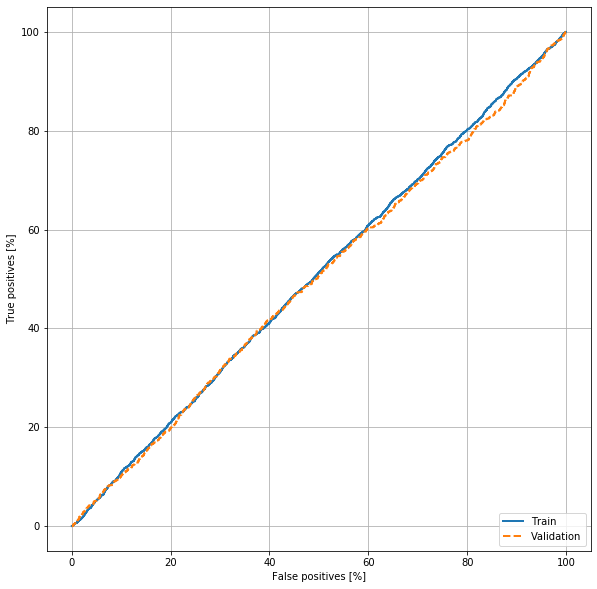

In [41]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

### Confusion matrix

Train data: 
TN: 37608 
FP: 61847 
FN: 891 
TP: 1488
Healthy Patients - correctly identified (True Negatives):  37608 0.3781408677291237
Healthy Patients - predicted to have glaucoma (False Positives):  61847 0.6218591322708763
Glaucoma Patients - predicted healthy (False Negatives):  891 0.3745271122320303
Glaucoma Patients - correctly identified (True Positives):  1488 0.6254728877679697

Total Glaucoma patients:  2379 1.0
Total Healthy patients:  99455 1.0


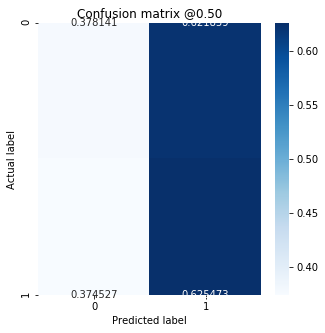

In [42]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_tr > 0.5).ravel()
train_cm = [tn, fp, fn, tp]
print("Train data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(train_labels, pred_tr)

Validation data: 
TN: 19227 
FP: 13907 
FN: 456 
TP: 353
Healthy Patients - correctly identified (True Negatives):  19227 0.5802800748475886
Healthy Patients - predicted to have glaucoma (False Positives):  13907 0.4197199251524114
Glaucoma Patients - predicted healthy (False Negatives):  456 0.5636588380716935
Glaucoma Patients - correctly identified (True Positives):  353 0.4363411619283066

Total Glaucoma patients:  809 1.0
Total Healthy patients:  33134 1.0


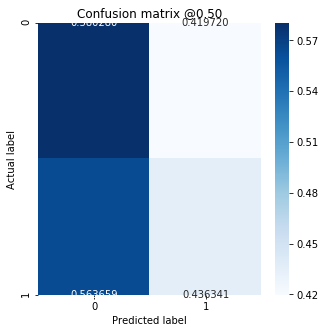

In [43]:
tn, fp, fn, tp = confusion_matrix(val_labels, pred_vl > 0.5).ravel()
val_cm = [tn, fp, fn, tp]
print("Validation data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(val_labels, pred_vl)

### MLFlow 

In [44]:
# get_notebook_name()

In [45]:
# history = up3_history
# tag_value = "same as copy 5 with feature wise centre = True"

# exp_name = get_notebook_name()+"-run at-"+datetime.datetime.now().strftime("%d%b%Y %H:%M")
# keras_model_path = funduspath_CR+ exp_name + '_model'
# save_mlflow(keras_model_path,exp_name,which_gt,which_model,seq,BATCH_SIZE,
#             n_epochs,n_steps_per_epoch,n_validation_steps,
#             reg_value,learning_rate,decay,opt,
#             history,results_tr,results_vl,train_cm,val_cm
#            )

In [46]:
# client = MlflowClient()
# run = client.create_run('22')
# client.set_tag(run.info.run_id, "tag_key", tag_value)

## Performance on TEST Data

In [52]:
valid_testdf_names[Class] = valid_testdf_names[Class].astype(int)
test_datagen = ImageDataGenerator(samplewise_center=True,
                                 featurewise_center=True, featurewise_std_normalization=True,
                                 rescale=1./127.5-1)  
test_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_testdf_names,
    directory=testpath,
    x_col=valid_testdf_names.columns[0],
    y_col=valid_testdf_names.columns[which_gt],
    class_mode="raw",
    target_size=(red_size, red_size),
    batch_size=BATCH_SIZE
)

Found 33936 validated image filenames.


### Evaluation on test data

In [53]:
results_test = model.evaluate(test_generator,steps=100)


100/100 [==============================] - 69s 687ms/step


In [63]:
print("NAME :\t\t\tVALIDATION :\t\t\tTEST ")
for name,value_val, value_test in zip(model.metrics_names, results_vl, results_test):
    print(name,"\t\t",value_val,"\t\t", value_test)


NAME :			VALIDATION :			TEST 
loss 		 0.6538366079330444 		 0.6900187134742737
Accuracy 		 0.5703125 		 0.5684375166893005
Precision 		 0.024872753769159317 		 0.02726435661315918
Recall 		 0.23499998450279236 		 0.27916663885116577
F1 		 0.04412924125790596 		 0.048069704324007034
AUC 		 0.5369114279747009 		 0.5943062901496887


In [64]:
pred_test = model.predict(test_generator)

In [65]:
np.save(funduspath_CR + str(n_epochs) + 'ep_train_M7_latest.npy', pred_tr)
np.save(funduspath_CR + str(n_epochs) + 'ep_val_M7_latest.npy', pred_vl)
np.save(funduspath_CR + str(n_epochs) + 'ep_test_M7_latest.npy', pred_test)

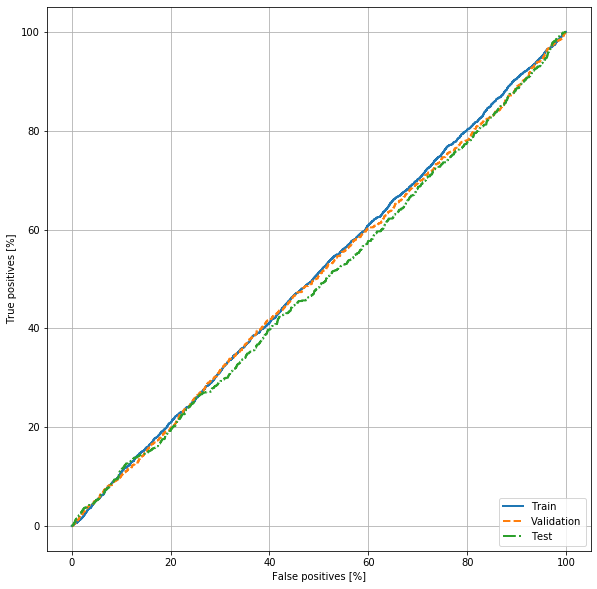

In [67]:
plt.figure(figsize=(10,10))
plot_roc("Train", train_labels, pred_tr, color=colors[0])
plot_roc("Validation", val_labels, pred_vl, color=colors[1],linestyle='--')
plot_roc("Test", test_labels, pred_test, color=colors[2],linestyle='-.')
# plot_roc("Validation", val_labels, val_class, color=colors[3],linestyle='-.') # theshold 0.1
plt.legend(loc='lower right')

Test data: 
TN: 19140 
FP: 14023 
FN: 443 
TP: 330
Healthy Patients - correctly identified (True Negatives):  19140 0.5771492325784761
Healthy Patients - predicted to have glaucoma (False Positives):  14023 0.422850767421524
Glaucoma Patients - predicted healthy (False Negatives):  443 0.5730918499353169
Glaucoma Patients - correctly identified (True Positives):  330 0.4269081500646831

Total Glaucoma patients:  773 1.0
Total Healthy patients:  33163 1.0


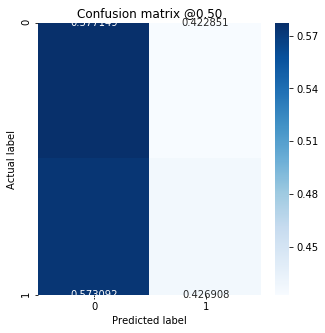

In [68]:
tn, fp, fn, tp = confusion_matrix(test_labels, pred_test > 0.5).ravel()
test_cm = [tn, fp, fn, tp]
print("Test data: \nTN:",tn,"\nFP:",fp,"\nFN:",fn,"\nTP:",tp)
plot_cm(test_labels, pred_test)